<center><h2>Inter-IIT Tech Meet 2018</h2> 
<h3> Optimal Bidding</h3><br></center>
<b>Author</b> : Alan Aipe <br>
<b>Last Updated Date</b> : 17-12-2017 <br>
<b>Objectives</b> : 
1. Optimize oracle predictions with respect to real values.
2. Minimize total expenditure on electricity purchase for n-days.

In [20]:
# External libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy.signal import savgol_filter,wiener
from keras.models import load_model
import tensorflow as tf
import pickle

In [21]:
# Loading Training dataset
base_path_training = "Data_Training_Set/"
predicted_values_training = {}
real_values_training = {}
n1=1
n2=31
n_days=31
offset=0
predicted_values_training["Demand"] = (pd.read_csv(base_path_training+"Demand_Train_pred.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
predicted_values_training["Price"] = (pd.read_csv(base_path_training+"Price_Train_pred.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
predicted_values_training["SolarOutput"] = (pd.read_csv(base_path_training+"Solar_Train_pred.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
real_values_training["Demand"] = (pd.read_csv(base_path_training+"Demand_Train.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
real_values_training["Price"] = (pd.read_csv(base_path_training+"Price_Train.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
real_values_training["SolarOutput"] = (pd.read_csv(base_path_training+"Solar_Train.csv",header=None)).values.flatten()[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
# Loading Leaderboard dataset
base_path_leaderboard = "Data_Leaderboard/"
predicted_values_leaderboard_daily = {}
optimized_values_leaderboard_daily = {}
optimized_values_leaderboard = {}
predicted_values_leaderboard = {}
predicted_values_leaderboard["Demand"] = (pd.read_csv(base_path_leaderboard+"Demand_Test_pred.csv",header=None)).values.flatten()
predicted_values_leaderboard["Price"] = (pd.read_csv(base_path_leaderboard+"Price_Test_pred.csv",header=None)).values.flatten()
predicted_values_leaderboard["SolarOutput"] = (pd.read_csv(base_path_leaderboard+"Solar_Test_pred.csv",header=None)).values.flatten()

In [22]:
# predicted_values_leaderboard["Demand"]=predicted_values_training["Demand"]
# predicted_values_leaderboard["Price"]=predicted_values_training["Price"]
# predicted_values_leaderboard["SolarOutput"]=predicted_values_training["SolarOutput"]
# Global variables
n_days_training = 900
n_days_lb = 100
blocks_per_day = 24
battery_max_capacity = 25
battery_max_transfer_rate = 5
battery_discharging_efficiency = 0.8
n_blocks_lb = n_days_lb * blocks_per_day
discom_unit_price = 7
t_unit_price = discom_unit_price 
n_blocks_training = n_days_training * blocks_per_day

In [23]:
# Optimize predicted demand in leaderboard dataset
temp = predicted_values_leaderboard["Demand"] - predicted_values_leaderboard["SolarOutput"]
model = load_model('demand_opt_bilstm_model.h5')
optimized_non_solar_demand = np.array([])
for h in range(n_days_lb):
    ns_demand = temp[h*24:(h+1)*24]
    ns_demand_predicted = (np.reshape(model.predict(np.reshape(ns_demand,(1,24,1))),(1,24,))).flatten()
    optimized_non_solar_demand = np.concatenate((optimized_non_solar_demand,ns_demand_predicted.flatten()))
optimized_values_leaderboard["Demand"] = temp

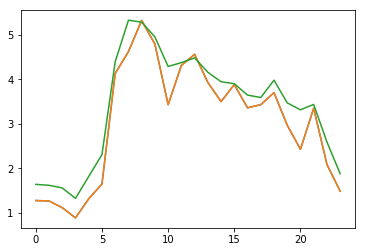

In [24]:
# Optmize predicted price in leaderboard dataset
def getLossFunction(a):
    def lossFunction(y_true,y_pred):
        return tf.pow(y_pred - y_true,2)*tf.pow(tf.sign(y_pred-y_true)+a,2)
    return lossFunction
temp = predicted_values_leaderboard["Price"]
plt.plot(range(24),temp[0:24])
model = load_model('price_opt_bilstm_model.h5',custom_objects={'lossFunction':getLossFunction(-0.1)})
y_pred = np.reshape(model.predict(np.reshape(temp,(n_days_lb,blocks_per_day,1))),(n_days_lb,blocks_per_day,))
for i in range(n_days_lb):
    val_range = max(y_pred[i])-min(y_pred[i])
    y_pred[i] += (1.5*(1-np.sqrt(y_pred[i]/max(y_pred[i])))+0.3*(abs(y_pred[i])/val_range))/2 
temp = y_pred.flatten()
temp[temp > discom_unit_price] = discom_unit_price
plt.plot(range(24),temp[0:24])
plt.show()
optimized_values_leaderboard["Price"] = temp

In [25]:
# Optimize predicted solar power plant output in leaderboard dataset
temp = predicted_values_leaderboard["SolarOutput"]
weight_vector = [0.56,0.11875,0.24875,0.06625]
n_savgolFilter = 3
solar_hour_start = 7
solar_hour_end = 18
model = load_model('solar_opt_bilstm_model.h5')
optimized_solar_output = np.array([])
for h in range(n_days_lb):
    solar_pred = temp[h*24:(h+1)*24]
    result = solar_pred
    wt_avg = weight_vector[0]*result
    for i in range(blocks_per_day-3):
            f = solar_pred[i+1]
            m1 = solar_pred[i+1]-solar_pred[i]
            m2 = solar_pred[i+2]-solar_pred[i+1]
            delta = 0
            flag = 0
            if m1<0 and m2>0:
                flag = 2
                if abs(m1)>abs(m2):
                    k = i+((solar_pred[i+2]-solar_pred[i])/(solar_pred[i+1]-solar_pred[i]))
                    if solar_pred[i+1] > solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0):
                        delta = (solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0)-solar_pred[i+1])
                    else:
                        delta = solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0) - solar_pred[i+1]
                elif abs(m1)<abs(m2):
                    k = i+2 - ((solar_pred[i+2]-solar_pred[i])/(solar_pred[i+2]-solar_pred[i+1]))
                    if solar_pred[i+1] > solar_pred[i]-((k-i)*(k-i)/4.0):
                        delta = (solar_pred[i]-((k-i)*(k-i)/4.0)-solar_pred[i+1])
                    else:
                        delta = solar_pred[i]-((k-i)*(k-i)/4.0)-solar_pred[i+1]
            delta =  abs(delta)
            if wt_avg[i+1]<wt_avg[i] and wt_avg[i+1]<wt_avg[i+2]:
                wt_avg[i+1]+= delta
            elif flag == 2 and wt_avg[i+1]<wt_avg[i] and wt_avg[i+1]>wt_avg[i+2]:
                wt_avg[i+1]-= delta
            elif flag == 2 and wt_avg[i+1]>wt_avg[i] and wt_avg[i+1]<wt_avg[i+2]:
                wt_avg[i+1]+= delta
    for i in range(n_savgolFilter):
            yhat = savgol_filter(x = result[solar_hour_start:solar_hour_end] , window_length=5,polyorder=3) #6th block to 18th block is considered because in other blocks outputis always zero
            yhat[yhat<0] = 0
            result = np.concatenate((solar_pred[:solar_hour_start],yhat,solar_pred[solar_hour_end:]))
            wt_avg+= weight_vector[i+1]*result
    wt_avg_rs = np.reshape(wt_avg,(-1,24,1))
    predicted_value = model.predict(wt_avg_rs[:,solar_hour_start-1:solar_hour_end+1,:])
    predicted_value = np.reshape(predicted_value,(13,))
    wt_avg = np.concatenate((wt_avg[:solar_hour_start-1],predicted_value,wt_avg[solar_hour_end+1:]))
    optimized_solar_output = np.concatenate((optimized_solar_output,wt_avg))

optimized_values_leaderboard["SolarOutput"] = optimized_solar_output
optimized_values_leaderboard["Demand"] =  optimized_solar_output + optimized_non_solar_demand

<b>Section 2</b> <br>
In this section, we intend to minimize total expenditure on electricity purchase with respect to optimized leaderboard values. Algorithm for the above objective involves following steps:
1. Find community demand which cannot be satisfied by solar power plant. Subtract solar output from overall demand to obtain this. We call it non-solar demand for the sake of convenience.
2. Using non-solar demand, redistribute demand between blocks, adhering to all constraints mentioned in the problem statement. For a given high priced block, non-solar demand is shifted from that block to closest solar energy excess points followed by low priced blocks. Demand is always shifted back in time so as to ensure temporal stability.

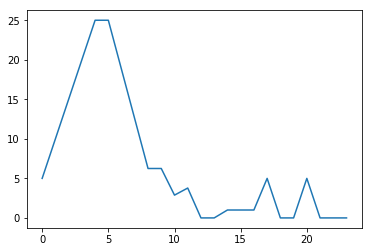

0.0


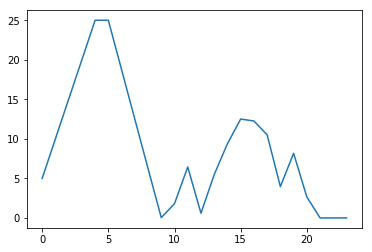

0.0


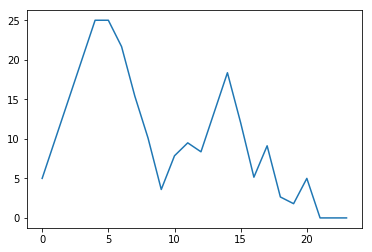

0.0


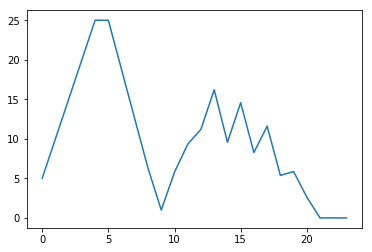

0.0


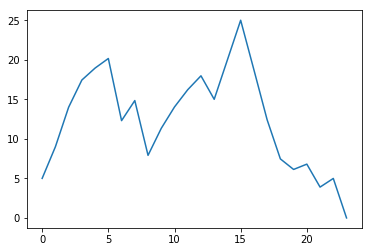

0.0


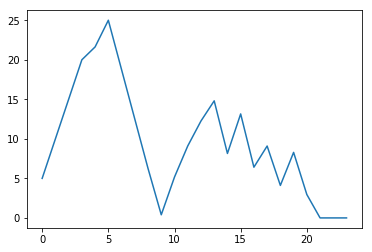

0.0


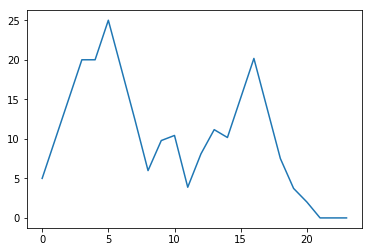

0.0


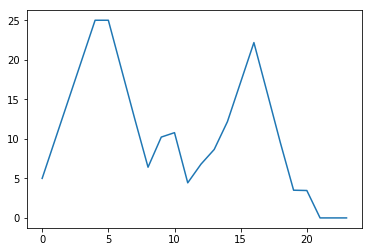

0.0


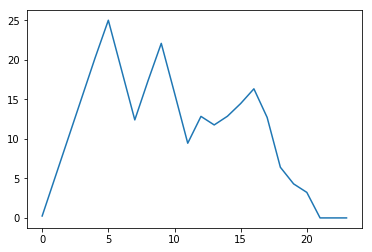

0.0


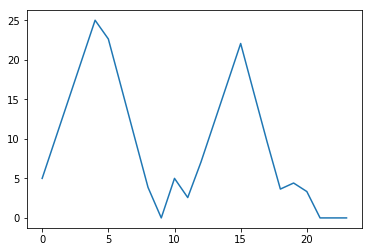

0.0


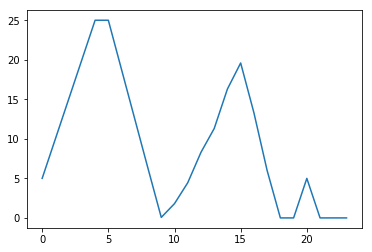

0.0


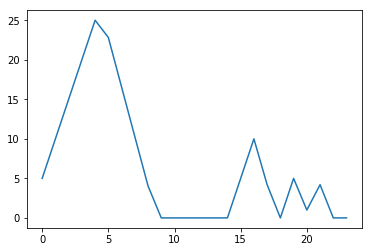

0.0


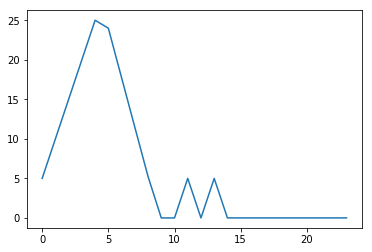

0.0


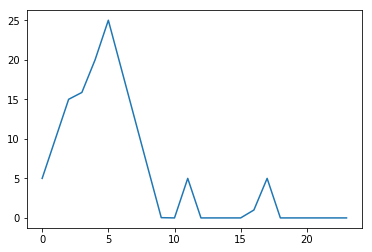

0.0


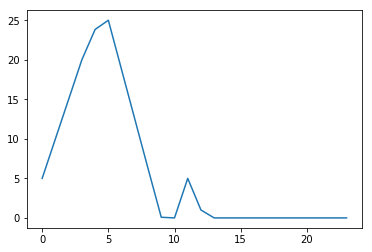

0.0


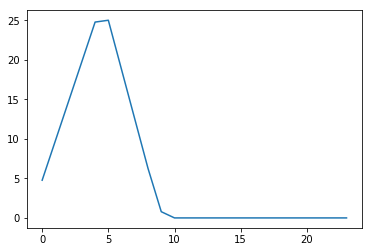

0.0


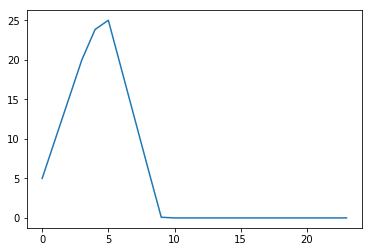

0.0


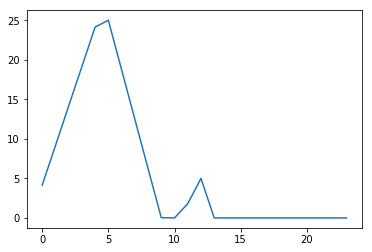

0.0


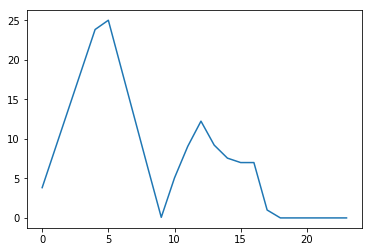

0.0


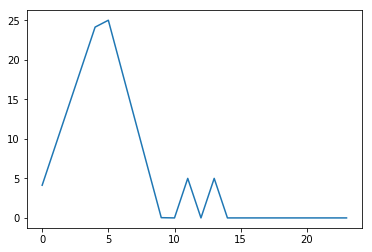

0.0


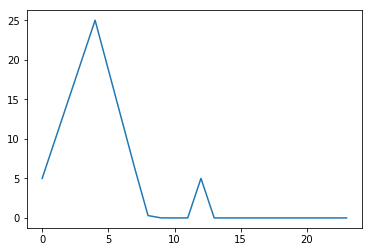

0.0


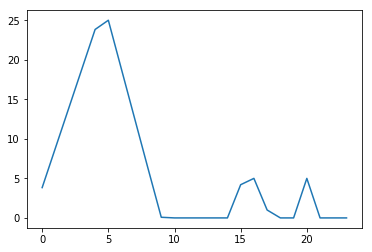

0.0


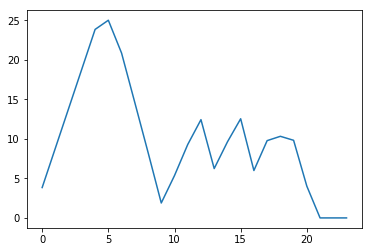

0.0


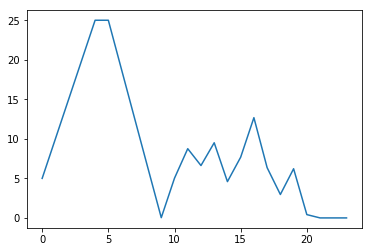

0.0


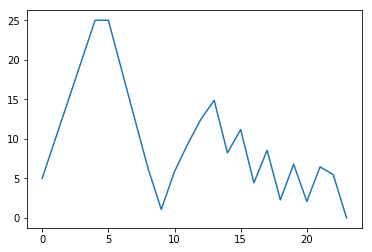

0.0


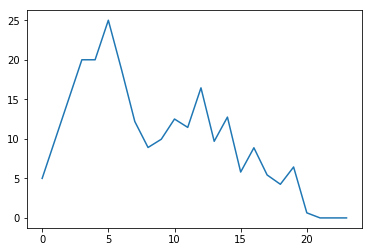

0.0


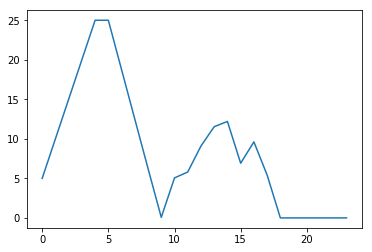

0.0


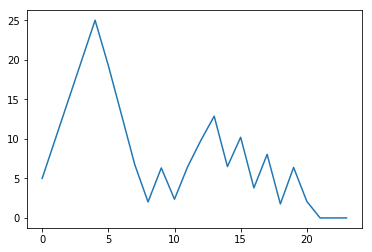

0.0


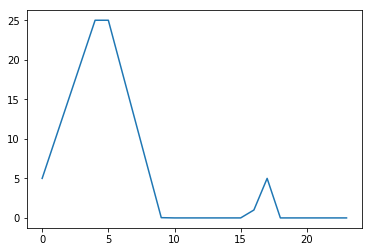

0.0


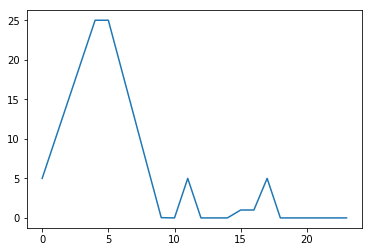

0.0


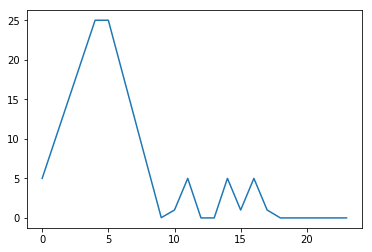

0.0


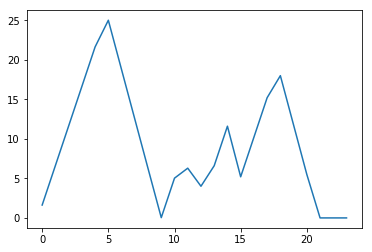

0.0


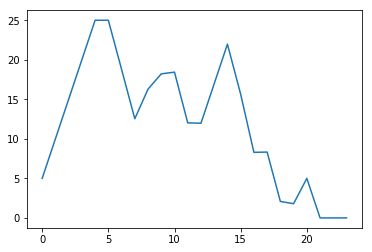

0.0


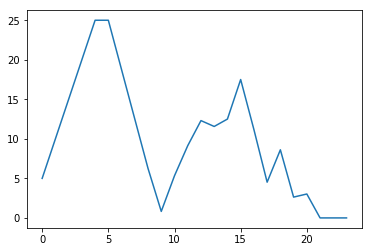

0.0


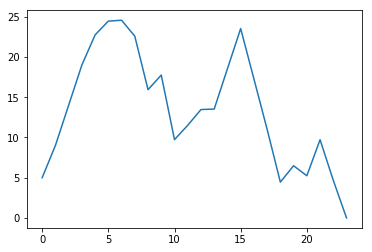

0.0


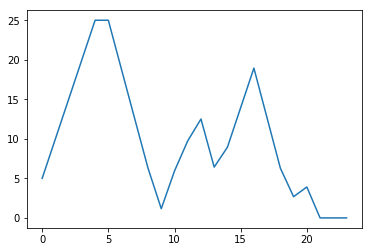

0.0


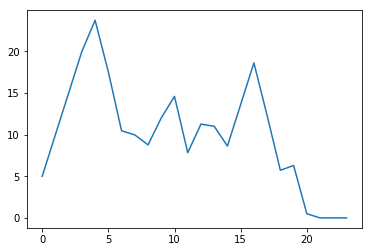

0.0


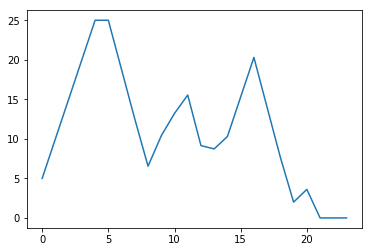

0.0


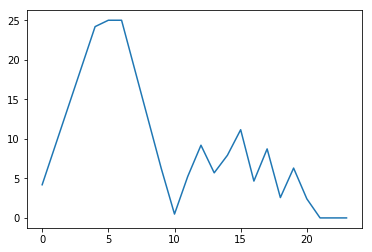

0.0


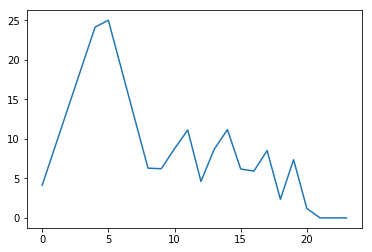

0.0


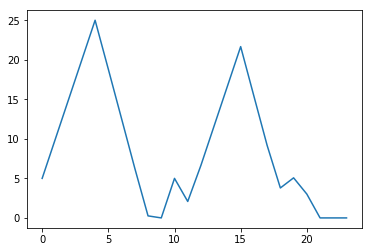

0.0


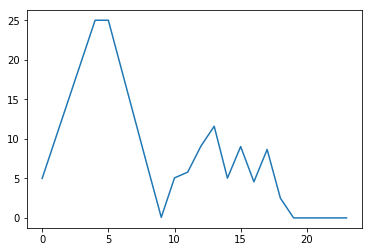

0.0


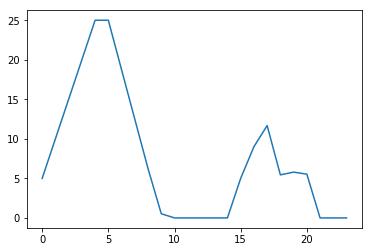

0.0


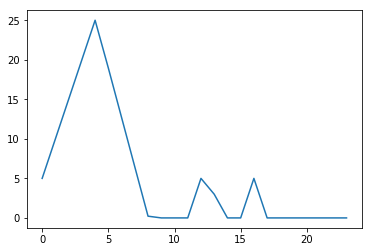

0.0


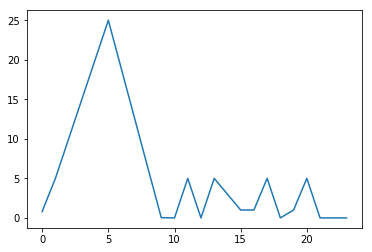

0.0


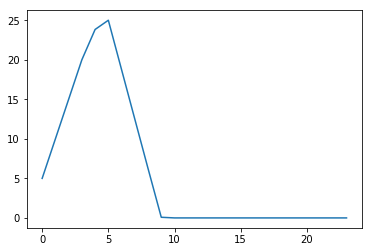

0.0


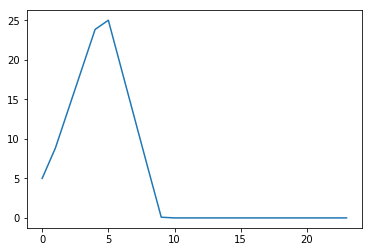

0.0


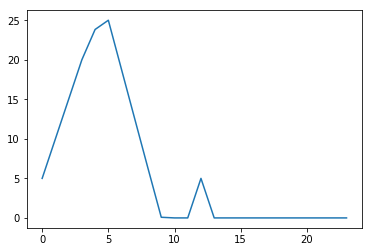

0.0


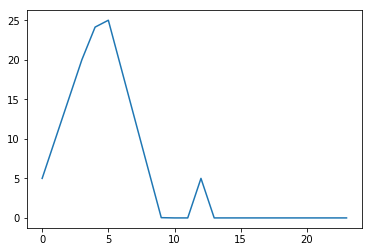

0.0


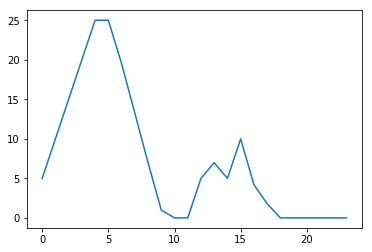

0.0


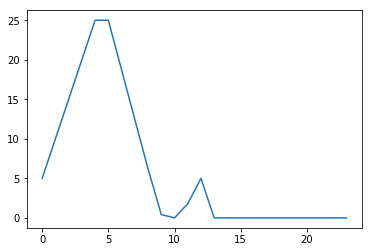

0.0


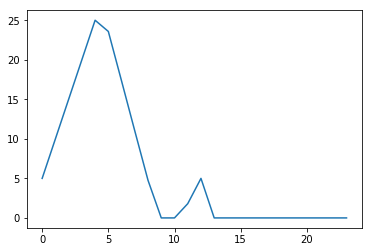

0.0


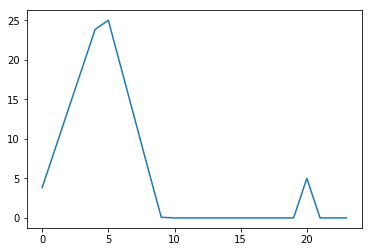

0.0


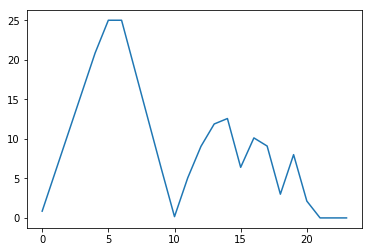

0.0


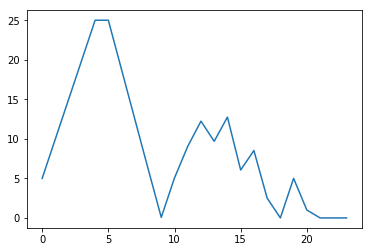

0.0


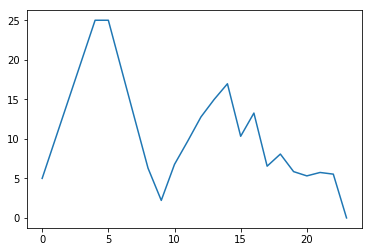

0.0


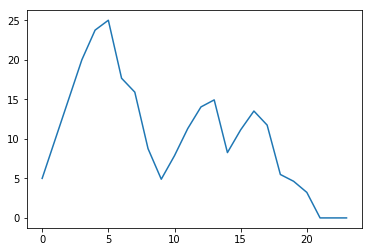

0.0


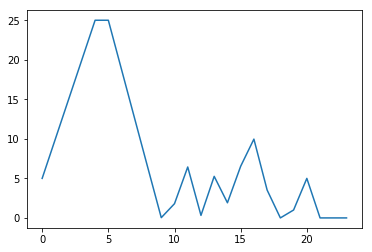

0.0


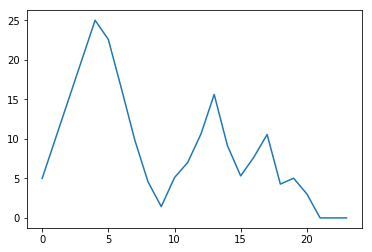

0.0


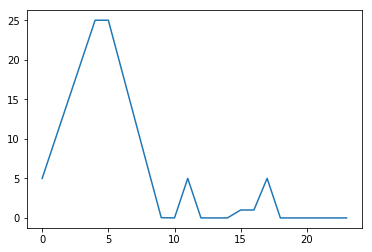

0.0


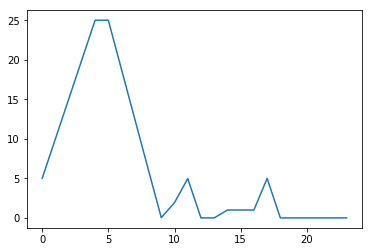

0.0


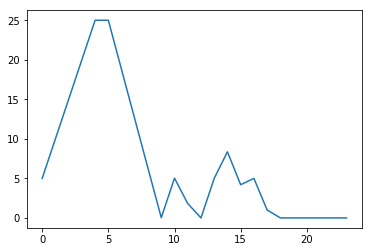

0.0


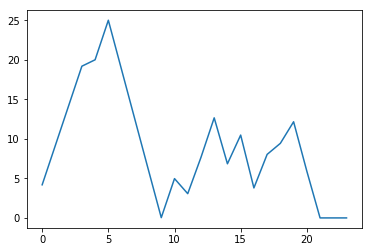

0.0


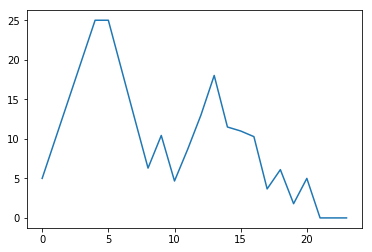

0.0


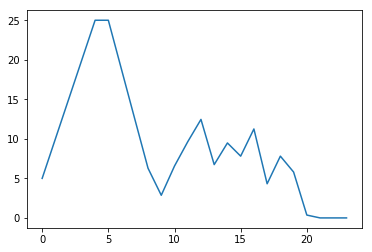

0.0


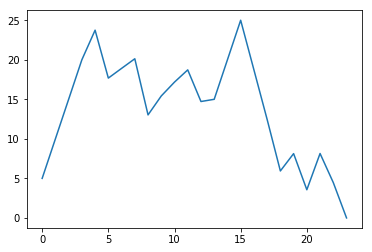

0.0


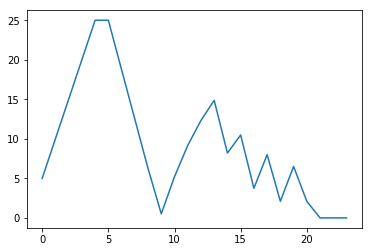

0.0


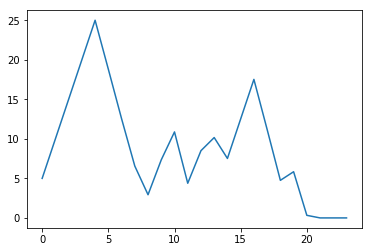

0.0


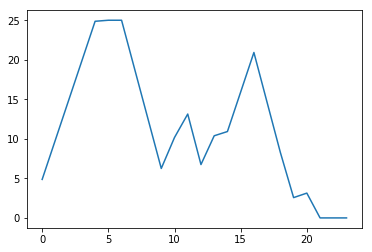

0.0


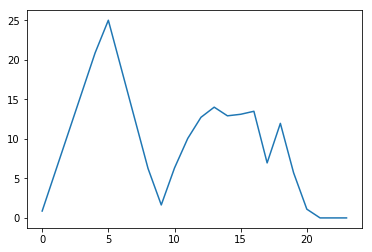

0.0


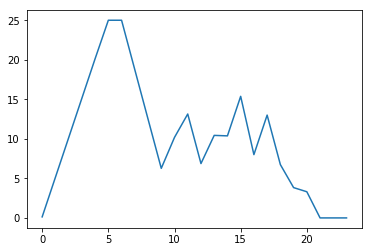

0.0


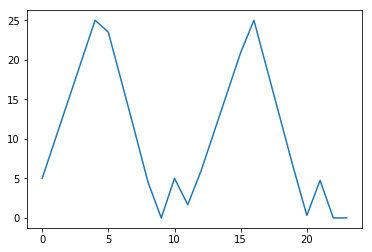

0.0


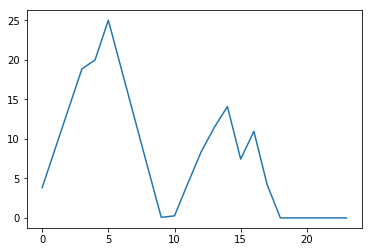

0.0


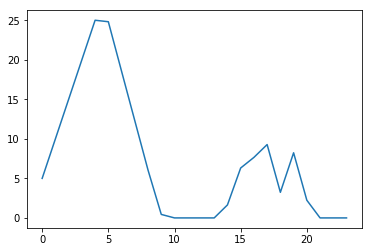

0.0


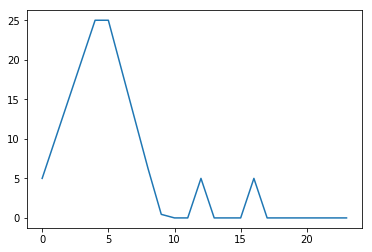

0.0


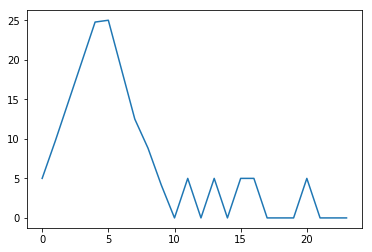

0.0


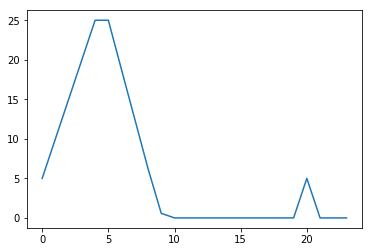

0.0


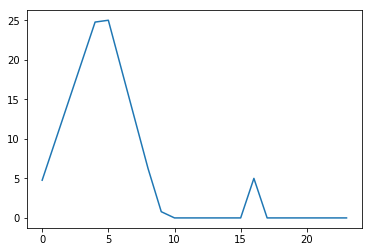

0.0


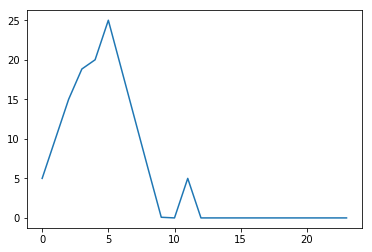

0.0


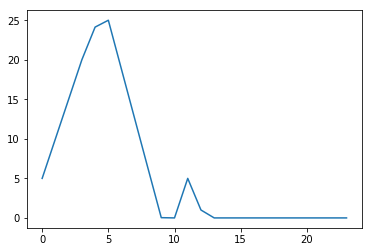

0.0


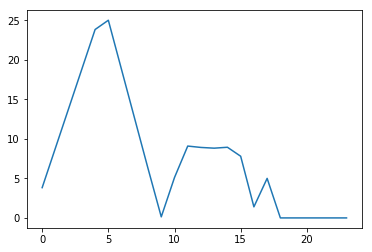

0.0


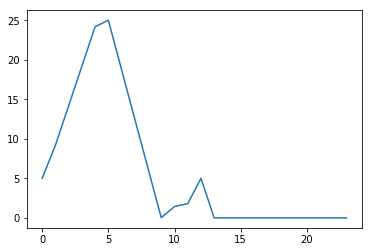

0.0


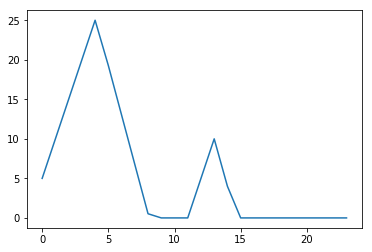

0.0


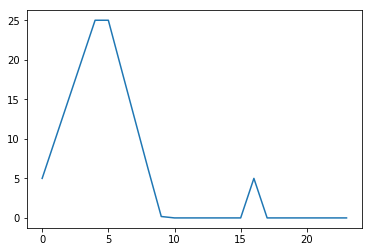

0.0


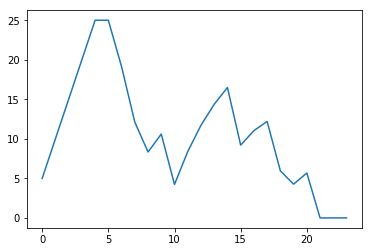

0.0


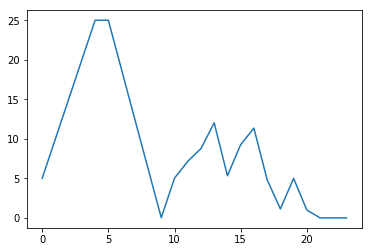

0.0


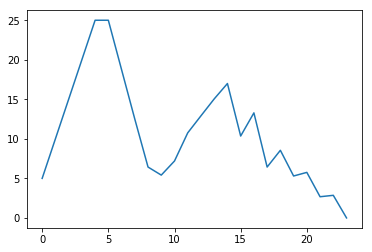

0.0


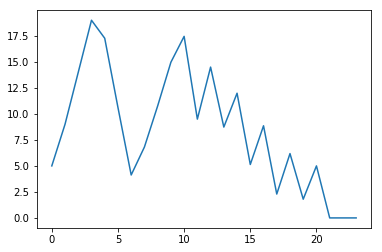

0.0


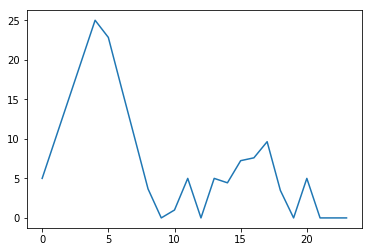

0.0


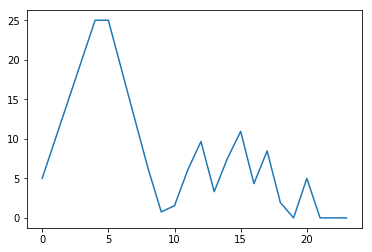

0.0


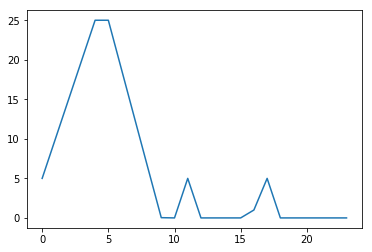

0.0


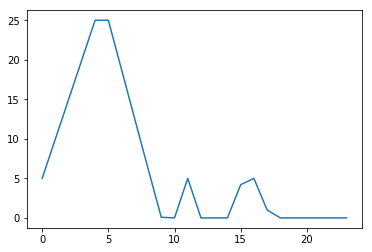

0.0


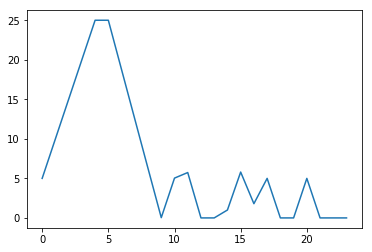

0.0


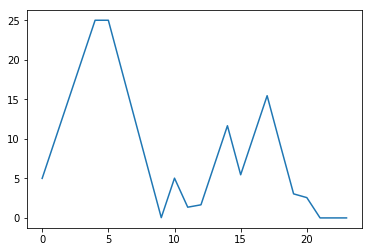

0.0


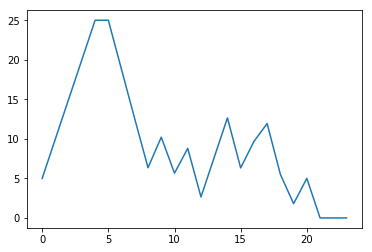

0.0


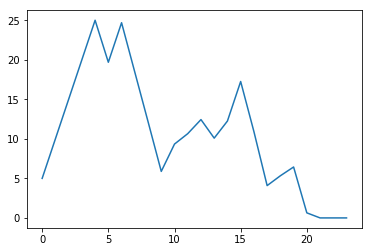

0.0


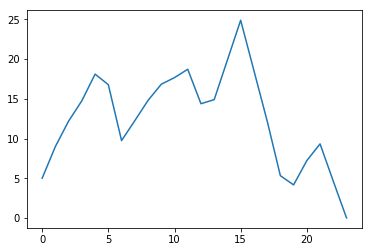

0.0


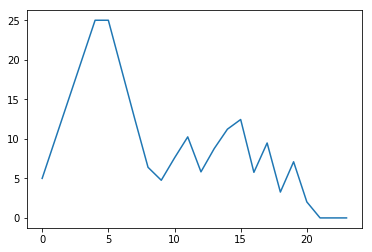

0.0


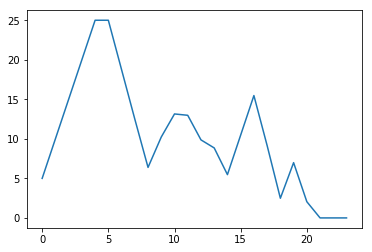

0.0


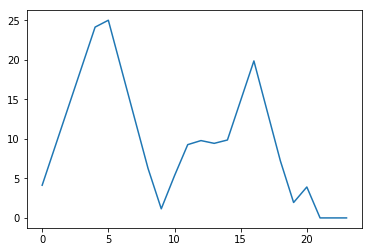

0.0
Average daily expenditure before optimization = Rs. 173.366041667
Average daily expenditure after optimization = Rs. 172.71855
416078.5 414524.52


In [26]:
def reverse_sort_index(price_sort_index,price):
    i = 0
    j = 0
    n = len(price_sort_index)
    while(j<n):
        if price[i]==price[j]:
            j+=1
            continue
        else:
            if j-i > 1:
                price_sort_index = np.concatenate((price_sort_index[:i],np.flip(price_sort_index[i:j],axis=-1),price_sort_index[j:]))
            i = j
    return price_sort_index
daily_avg_nonopt = 0
daily_avg_opt = 0
final_bid_price = []
final_bid_quantity = []
total_expenditure_lb_non_opt = 0.0
total_expenditure_lb_opt = 0.0
battery_charge_left = 0.0
day_split =1
m=0
for h in range(0,n_days_lb):
    if m>=n_days_lb:
        break
    m += day_split
    # print("Day",h+1)
    optimized_values_leaderboard_daily["Demand"] = optimized_values_leaderboard["Demand"][h*24:int((h+day_split)*24)]
    optimized_values_leaderboard_daily["Price"] = optimized_values_leaderboard["Price"][h*24:int((h+day_split)*24)]
    optimized_values_leaderboard_daily["SolarOutput"] = optimized_values_leaderboard["SolarOutput"][h*24:int((h+day_split)*24)]
    predicted_values_leaderboard_daily["Price"] = predicted_values_leaderboard["Price"][h*24:int((h+day_split)*24)]
    predicted_values_leaderboard_daily["Price1"] = predicted_values_leaderboard["Price"][h*24:int((h+day_split)*24)]
    days = int(np.size(optimized_values_leaderboard_daily["Demand"])/24.0)
    battery_charging_block = np.zeros(int(days*blocks_per_day))
    battery_discharging_block = np.zeros(int(days*blocks_per_day))
    battery_usage_block = np.zeros(int(days*blocks_per_day))
    discom_unit_price = min(optimized_values_leaderboard_daily["Price"])+0.5*((max(optimized_values_leaderboard_daily["Price"])-min(optimized_values_leaderboard_daily["Price"]))/3)
    discom_unit_price = min(discom_unit_price,np.sort(optimized_values_leaderboard_daily["Price"])[int(0.3*np.size(optimized_values_leaderboard_daily["Price"]))])
    non_solar_demand = optimized_values_leaderboard_daily["Demand"] - optimized_values_leaderboard_daily["SolarOutput"]
    price_desc_sort_index = np.argsort(-optimized_values_leaderboard_daily["Price"])
    price_desc_sort_index = reverse_sort_index(price_desc_sort_index,optimized_values_leaderboard_daily["Price"])
    price_asc_sort_index = np.argsort(optimized_values_leaderboard_daily["Price"])
    price_asc_sort_index = reverse_sort_index(price_asc_sort_index,optimized_values_leaderboard_daily["Price"])
    #Extra
    positive_demand = 0
    total_excess_energy = 0
    total_money_spent = 0
    for j in range(len(non_solar_demand)):
        i = non_solar_demand[j]
        if i>0:
            positive_demand+=i
            if optimized_values_leaderboard_daily["Price"][j]<7: # If predicted price is lesser than discom unit price, then buy from market with real price
                total_money_spent += predicted_values_leaderboard_daily["Price"][j]*i
            else:
                total_money_spent += 7*i

        elif i<0:
            total_excess_energy-=i
    total_money_spent = np.round(total_money_spent,2)
    total_expenditure_lb_non_opt += total_money_spent
    daily_avg_nonopt += total_money_spent/blocks_per_day
    # print(total_money_spent/blocks_per_day,positive_demand,total_excess_energy)
    #EndExtra
    count = 1
    for i in price_desc_sort_index:
        count+=1
        j = i-1
        demand = non_solar_demand[i]
        #Satisfy demand with leftover battery charge
        path_energy = float("inf")
        if battery_charge_left>0:
            for k in range(i-1,0,-1):
                excess_energy = 0.0
                if predicted_values_leaderboard_daily["Price1"][k]>=7 and non_solar_demand[k]>0 :
                    excess_energy = min(non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                path_energy = excess_energy + min(path_energy,battery_max_capacity - battery_usage_block[k])
            energy_transferred_to_battery = min(path_energy,battery_charge_left,demand/battery_discharging_efficiency,battery_max_transfer_rate-abs(battery_charging_block[i]-battery_discharging_block[i]))
            battery_charge_left -= energy_transferred_to_battery
            if energy_transferred_to_battery > 0:
                for k in range(0,i):
                    excess_energy = 0.0
                    if predicted_values_leaderboard_daily["Price1"][k]>=7:
                        excess_energy = min(energy_transferred_to_battery,non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                    battery_discharging_block[k] += battery_discharging_efficiency*excess_energy
                    battery_usage_block[k] += (energy_transferred_to_battery - excess_energy)
                    non_solar_demand[k] -= battery_discharging_efficiency*excess_energy
                    energy_transferred_to_battery -= excess_energy
                    if energy_transferred_to_battery<=0:
                        break
                battery_usage_block[i] += energy_transferred_to_battery
                energy_transferred_from_battery = energy_transferred_to_battery
                battery_usage_block[i] -= energy_transferred_from_battery
                usable_energy = battery_discharging_efficiency*energy_transferred_from_battery
                battery_discharging_block[i] += battery_discharging_efficiency*energy_transferred_from_battery
                non_solar_demand[i] -= usable_energy
                demand -= usable_energy
        #Satisfying demand with excess solar energy from blocks from past
        while total_excess_energy>0 and j >= 0 and demand > 0 and abs(battery_charging_block[i]-battery_discharging_block[i])<battery_max_transfer_rate:
            if non_solar_demand[j] < 0:
                path_energy = float("inf")
                for k in range(i-1,j,-1):
                    excess_energy = 0.0
                    if predicted_values_leaderboard_daily["Price1"][k]>=7 and non_solar_demand[k]>0 :
                        excess_energy = min(non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                    path_energy = excess_energy + min(path_energy,battery_max_capacity - battery_usage_block[k])
                energy_transferred_to_battery = min(battery_max_capacity - battery_usage_block[j],demand/battery_discharging_efficiency,battery_max_transfer_rate-abs(battery_charging_block[i]-battery_discharging_block[i]),abs(non_solar_demand[j]),path_energy,battery_max_transfer_rate-abs(battery_charging_block[j]-battery_discharging_block[j]))
                if energy_transferred_to_battery > 0:
                    total_excess_energy -= energy_transferred_to_battery
                    non_solar_demand[j] += energy_transferred_to_battery
                    battery_charging_block[j] += energy_transferred_to_battery
                    battery_usage_block[j] += energy_transferred_to_battery
                    for k in range(j+1,i):
                        excess_energy = 0.0
                        if predicted_values_leaderboard_daily["Price1"][k]>=7:
                            excess_energy = min(energy_transferred_to_battery,non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                        battery_discharging_block[k] += battery_discharging_efficiency*excess_energy
                        battery_usage_block[k] += (energy_transferred_to_battery - excess_energy)
                        non_solar_demand[k] -= battery_discharging_efficiency*excess_energy
                        energy_transferred_to_battery -= excess_energy
                        if energy_transferred_to_battery<=0:
                            break
                    battery_usage_block[i] += energy_transferred_to_battery
                    energy_transferred_from_battery = energy_transferred_to_battery
                    battery_usage_block[i] -= energy_transferred_from_battery
                    usable_energy = battery_discharging_efficiency*energy_transferred_from_battery
                    battery_discharging_block[i] += battery_discharging_efficiency*energy_transferred_from_battery
                    non_solar_demand[i] -= usable_energy
                    demand -= usable_energy
            j -= 1
        # Satisfying remaining demand with shifting demand to low price blocks from past
        for j in price_asc_sort_index:
            if demand <= 0:
                break
            if optimized_values_leaderboard_daily["Price"][j] < optimized_values_leaderboard["Price"][i] and j<i:
                path_energy = float("inf")
                for k in range(i-1,j,-1):
                    excess_energy = 0.0
                    if predicted_values_leaderboard_daily["Price1"][k]>=discom_unit_price and non_solar_demand[k]>0 :
                        excess_energy = min(non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                    path_energy = excess_energy + min(path_energy,battery_max_capacity - battery_usage_block[k])
                energy_transferred_to_battery = min(battery_max_capacity - battery_usage_block[j],demand/battery_discharging_efficiency,battery_max_transfer_rate-abs(battery_charging_block[i]-battery_discharging_block[i]),path_energy,battery_max_transfer_rate-abs(battery_charging_block[j]-battery_discharging_block[j]))
                if energy_transferred_to_battery > 0:
                    non_solar_demand[j] += energy_transferred_to_battery
                    battery_charging_block[j] += energy_transferred_to_battery
                    battery_usage_block[j] += energy_transferred_to_battery
                    for k in range(j+1,i):
                        excess_energy = 0.0
                        if predicted_values_leaderboard_daily["Price1"][k]>=discom_unit_price:
                            excess_energy = min(energy_transferred_to_battery,non_solar_demand[k]/battery_discharging_efficiency,battery_max_transfer_rate + battery_charging_block[k] - battery_discharging_block[k])
                        battery_discharging_block[k] += battery_discharging_efficiency*excess_energy
                        battery_usage_block[k] += (energy_transferred_to_battery - excess_energy)
                        non_solar_demand[k] -= battery_discharging_efficiency*excess_energy
                        energy_transferred_to_battery -= excess_energy
                        if energy_transferred_to_battery<=0:
                            break
                    battery_usage_block[i] += energy_transferred_to_battery
                    energy_transferred_from_battery = energy_transferred_to_battery
                    battery_usage_block[i] -= energy_transferred_from_battery
                    usable_energy = battery_discharging_efficiency*energy_transferred_from_battery
                    battery_discharging_block[i] += battery_discharging_efficiency*energy_transferred_from_battery
                    non_solar_demand[i] -= usable_energy
                    demand -= usable_energy
    plt.plot(range(np.size(battery_usage_block)),battery_usage_block)
    plt.show()
    battery_charge_left = battery_usage_block[np.size(battery_usage_block)-1]
    #Extra
    positive_demand = 0
    total_excess_energy = 0
    total_money_spent = 0
    for j in range(len(non_solar_demand)):
        i = non_solar_demand[j]
        if i>0:
            positive_demand+=i
            if optimized_values_leaderboard_daily["Price"][j]< 7 : # If predicted price is lesser than discom unit price, then buy from market with real price
                total_money_spent += predicted_values_leaderboard_daily["Price"][j]*i
            else:
                total_money_spent += 7*i

        elif i<0:
            total_excess_energy-=i
    total_money_spent = np.round(total_money_spent,2)
    total_expenditure_lb_opt += total_money_spent
    # print(total_money_spent/blocks_per_day,positive_demand,total_excess_energy)
    daily_avg_opt += total_money_spent/blocks_per_day
    for i in range(np.size(battery_usage_block)):
        if optimized_values_leaderboard_daily["Price"][i] < 7  and non_solar_demand[i] > 0:
            final_bid_price.append(optimized_values_leaderboard_daily["Price"][i])
            final_bid_quantity.append(non_solar_demand[i])
        else:
            final_bid_price.append(0)
            final_bid_quantity.append(0)
    print(battery_charge_left)
print("Average daily expenditure before optimization = Rs.",daily_avg_nonopt/100)
print("Average daily expenditure after optimization = Rs.",daily_avg_opt/100)
print(total_expenditure_lb_non_opt,total_expenditure_lb_opt)
ob_df = pd.DataFrame(data={'price':final_bid_price,'quantity':final_bid_quantity})
ob_df.to_csv('18.csv',header=False,index=False)
# plt.plot(range(blocks_per_day),battery_usage_block)
# plt.show()
# plt.plot(range(blocks_per_day),abs(battery_charging_block-battery_discharging_block))
# plt.show()
# print("Efficiency of algorithm w.r.t battery usage until this stage = ",np.round(100*simps(battery_usage_block,dx=1)/(battery_max_capacity*int(blocks_per_day)),2),"%")
#EndExtra